# One Jupyter notebook. From GeoJSON to .xml 

## Imports

In [1]:
import geopandas
import pandas
import numpy
import tifffile
import shapely
# import streamlit as st
from lmd.lib import Collection
from pathlib import Path
import ast
import string

In [2]:
from loguru import logger
import sys
logger.remove()
logger.add(sys.stdout, format="<green>{time:HH:mm:ss.SS}</green> | <level>{level}</level> | {message}")

1

## From GeoJSON to Dataframe

In [16]:
#user defined variables:
path_to_file = '/Users/jnimoca/Downloads/Wenhan.geojson'
path_to_save_files = '/Users/jnimoca/Desktop/'
#the naming of these should match exactly the names in the geoJSON file
calibration_points = ['X1','X2','X3']

### Samples and wells

In [3]:
# if you want to pass a custom well loadout use the following dictionary:  
# The dictionary keys will have to be the class name used in qupath, it has to be the exact names.  
# please choose wells with a 2-row 2-column margin. not rows (A, B, N, O) not columns (1,2,23,24)  

In [4]:
samples_and_wells = { "AF488S" : "C4", " AF488" : "C6", "AF647" : "C8", "AF488+AF647" : "C10", "AF555" : "C12", " AF488+AF555" : "C14"}

# Quality Control geojson

In [5]:
def QC_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):

    df = geopandas.read_file(geojson_path)
    logger.info(f"Geojson file loaded with shape {df.shape}")
    
    try:
        df['annotation_name'] = df['name']
    except:
        logger.warning('No name column found, meaning no annotation in Qupath was named, at least calibration points should be named')
        sys.exit()

    geometry_counts = df.geometry.geom_type.value_counts()
    log_message = ", ".join(f"{count} {geom_type}s" for geom_type, count in geometry_counts.items())
    logger.info(f"Geometries in DataFrame: {log_message}")

    #check for calibration points
    for point_name in list_of_calibpoint_names:
        if point_name not in df['annotation_name'].unique():
            logger.error(f'Your given annotation_name {point_name} is not present in the file')
            logger.error(f'These are the calib points you passed: {list_of_calibpoint_names}')
            logger.error(f"These are the calib points found in the geojson you gave me: {df[df['geometry'].geom_type == 'Point']['annotation_name']}")

    calib_np_array = numpy.array(
        [[  df.loc[df['name'] == point_name, 'geometry'].values[0].x,
            df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
            for point_name in list_of_calibpoint_names])
    
    def polygon_intersects_triangle(polygon, triangle):
        if isinstance(polygon, shapely.Polygon):
            return polygon.intersects(triangle)
        elif isinstance(polygon, shapely.LineString):
            return polygon.intersects(triangle)
        else:
            return False  # Return False for other geometry types

    df['intersects'] = df['geometry'].apply(lambda x: polygon_intersects_triangle(x, shapely.Polygon(calib_np_array)))

    num_of_polygons_and_LineString = df[df['geometry'].geom_type.isin(['Polygon', 'LineString'])].shape[0]

    intersect_fraction = df['intersects'].sum()/num_of_polygons_and_LineString
    logger.info(f" {intersect_fraction*100:.2f}% of polygons are within calibration triangle")
    if intersect_fraction < 0.25:
        logger.warning(f"Less than 25% of the objects intersect with the calibration triangle")
        logger.warning(f"Polygons will most likely be warped, consider changing calib points")

    #remove points
    df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
    logger.debug(f"Point geometries have been removed")

    #check and remove empty classifications
    if df['classification'].isna().sum() !=0 :
        logger.info(f"You have {df['classification'].isna().sum()} NaNs in your classification column")
        logger.info(f"These are unclassified objects from Qupath, they will be removed")
        df = df[df['classification'].notna()]

    #rename classification
    df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))

    logger.debug(f"Checking for MultiPolygon objects")
    if 'MultiPolygon' in df.geometry.geom_type.value_counts().keys():
        logger.debug(f"MultiPolygon objects present:  {df.geometry.geom_type.value_counts()['MultiPolygon']}")
        logger.debug(f"These are not supported, and will be removed")
        df = df[df.geometry.geom_type != 'MultiPolygon']
    
    def extract_coordinates(geometry):
        if geometry.geom_type == 'Polygon':
            return [list(coord) for coord in geometry.exterior.coords]
        elif geometry.geom_type == 'LineString':
            return [list(coord) for coord in geometry.coords]
        else:
            return None 

    logger.debug(f"Extracting coordinates from geometries")
    df['coords'] = df.geometry.simplify(1).apply(extract_coordinates)

    logger.success(f"QC of geojson file complete")

# Setup geojson processing

In [6]:
def load_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):

   df = geopandas.read_file(geojson_path)

   calib_np_array = numpy.array(
      [[ df.loc[df['name'] == point_name, 'geometry'].values[0].x,
         df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
         for point_name in list_of_calibpoint_names])

   df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
   df = df[df['classification'].notna()]
   df = df[df.geometry.geom_type != 'MultiPolygon']

   def extract_coordinates(geometry):
      if geometry.geom_type == 'Polygon':
         return [list(coord) for coord in geometry.exterior.coords]
      elif geometry.geom_type == 'LineString':
         return [list(coord) for coord in geometry.coords]

   df['coords'] = df.geometry.simplify(1).apply(extract_coordinates)
   df['Name'] = df['classification'].apply(lambda x: x.get('name'))

   return df, calib_np_array

In [7]:
def create_list_of_acceptable_wells():
    list_of_acceptable_wells =[]
    for row in list(string.ascii_uppercase[1:14]):
        for column in range(2,22):
            list_of_acceptable_wells.append(str(row) + str(column))
    return list_of_acceptable_wells

In [8]:
def create_default_samples_and_wells(df):
    list_of_acceptable_wells = create_list_of_acceptable_wells()
    samples_and_wells = {}
    for sample in df["Name"]:
        samples_and_wells[sample] = list_of_acceptable_wells.pop(0)
    return samples_and_wells

In [9]:
def load_and_QC_SamplesandWells(samples_and_wells_input):

   samples_and_wells_processed = samples_and_wells_input.replace("\n", "")
   samples_and_wells_processed = samples_and_wells_processed.replace(" ", "")
   samples_and_wells = ast.literal_eval(samples_and_wells_processed)

   # check if the wells are in the list of acceptable wells
   for key, value in samples_and_wells.items():
      if value not in create_list_of_acceptable_wells():
         logger.error(f"Your well {value} for sample {key} is not in the list of acceptable wells")
         logger.error(f"Please choose wells that are not rows (A,O) not columns (1,22,23,24)")
         sys.exit()

In [10]:
def sample_placement_384wp(samples_and_wells):
    #create and export dataframe with sample placement in 384 well plate
    rows_A_P= [i for i in string.ascii_uppercase[:16]]
    columns_1_24 = [str(i) for i in range(1,25)]
    df_wp384 = pandas.DataFrame('',columns=columns_1_24, index=rows_A_P)
    #fill in the dataframe with samples and wells
    for i in samples_and_wells:
        location = samples_and_wells[i]
        df_wp384.at[location[0],location[1:]] = i
    #save dataframe as csv
    df_wp384.to_csv(f"./384_wellplate.csv", index=True)

In [11]:
def create_collection(df, calib_np_array, samples_and_wells=None):

    # if no samples and wells are given, create default samples and wells
    if samples_and_wells == None:
        samples_and_wells = create_default_samples_and_wells(df)

    the_collection = Collection(calibration_points = calib_np_array)
    the_collection.orientation_transform = numpy.array([[1,0 ],[0,-1]])
    for i in df.index:
        the_collection.new_shape(df.at[i,'coords'], well = samples_and_wells[df.at[i, "Name"]])

    sample_placement_384wp(samples_and_wells)

    the_collection.plot(save_name= "./TheCollection.png")
    the_collection.save(f"./LMD_ready_contours.xml")

# Check geojsons

In [12]:
paths = []
for path in Path("/Users/jnimoca/Desktop/qupath").rglob("*.geojson"):
    paths.append(path)

In [31]:
calibration_points

['X1', 'X2', 'X3']

In [32]:
geojson_path = path_to_file
#load geojson file
df = geopandas.read_file(geojson_path)
logger.info(f"Geojson file loaded with shape {df.shape}")

11:45:45.51 | INFO | Geojson file loaded with shape (43, 5)


In [33]:
try:
    df['annotation_name'] = df['name']
except:
    logger.warning('No name column found, meaning no annotation in Qupath was named, at least calibration points should be named')

In [35]:
df.head()

,id,objectType,classification,name,geometry,annotation_name
0,fc6a9688-c164-4984-bd98-f4ee852d74b3,annotation,NaN,X1,POINT (155.32000 1663.57000),X1
1,4c7cb112-c0a9-4bd7-8976-b1b0a527cff0,annotation,NaN,X2,POINT (1861.45000 530.99000),X2
2,04cdd52c-b10f-4105-b168-a7ee57edb4c5,annotation,NaN,X3,POINT (1527.71000 1345.29000),X3
3,bd9c44cf-f4c0-43cb-b62e-1527ec5ea72b,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((944.46000 900.54000, 943.34000 900.6...",NaN
4,3a74e70a-1c2e-42f0-99d3-0c7961b563ef,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((725.81000 1076.88000, 724.86000 1076...",NaN


In [36]:
geometry_counts = df.geometry.geom_type.value_counts()
log_message = ", ".join(f"{count} {geom_type}s" for geom_type, count in geometry_counts.items())
logger.info(f"Geometries in DataFrame: {log_message}")

11:46:30.33 | INFO | Geometries in DataFrame: 40 Polygons, 3 Points


In [37]:
list_of_calibpoint_names = calibration_points

for point_name in list_of_calibpoint_names:
    if point_name not in df['annotation_name'].unique():
        logger.error(f'Your given annotation_name {point_name} is not present in the file')
        logger.error(f'These are the calib points you passed: {list_of_calibpoint_names}')
        logger.error(f"These are the calib points found in the geojson you gave me: {df[df['geometry'].geom_type == 'Point']['annotation_name']}")

In [38]:
calib_np_array = numpy.array(
    [[ df.loc[df['name'] == point_name, 'geometry'].values[0].x,
        df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
        for point_name in list_of_calibpoint_names])

In [39]:
calib_np_array

array([[ 155.32, 1663.57],
       [1861.45,  530.99],
       [1527.71, 1345.29]])

In [40]:
def polygon_intersects_triangle(polygon, triangle):
        if isinstance(polygon, shapely.Polygon):
            return polygon.intersects(triangle)
        elif isinstance(polygon, shapely.LineString):
            return polygon.intersects(triangle)
        else:
            return False  # Return False for other geometry types

In [41]:
df['intersects'] = df['geometry'].apply(lambda x: polygon_intersects_triangle(x, shapely.Polygon(calib_np_array)))
num_of_polygons_and_LineString = df[df['geometry'].geom_type.isin(['Polygon', 'LineString'])].shape[0]

In [45]:
intersect_fraction = df['intersects'].sum()/num_of_polygons_and_LineString
logger.info(f" {intersect_fraction*100:.2f}% of polygons are within calibration triangle")

11:47:59.09 | INFO |  40.00% of polygons are within calibration triangle


In [47]:
#remove points
df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
logger.info(f"Point geometries have been removed")

11:48:21.76 | INFO | Point geometries have been removed


In [48]:
df.head()

,id,objectType,classification,name,geometry,annotation_name,intersects
3,bd9c44cf-f4c0-43cb-b62e-1527ec5ea72b,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((944.46000 900.54000, 943.34000 900.6...",NaN,False
4,3a74e70a-1c2e-42f0-99d3-0c7961b563ef,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((725.81000 1076.88000, 724.86000 1076...",NaN,False
5,c275935d-74ea-451d-9fd9-ad2d0d398151,annotation,"{'name': 'AF488+AF647', 'color': [230, 204, 255]}",NaN,"POLYGON ((922.00000 990.38000, 921.13000 990.4...",NaN,False
6,52e90c1a-5064-45e0-b5fe-c25fff827d3e,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((942.15000 1077.65000, 941.41000 1077...",NaN,False
7,06e71d3c-6014-4abf-9061-2253b629afc7,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((1111.56000 1344.85000, 1110.66000 13...",NaN,True


In [49]:
#check and remove empty classifications
if df['classification'].isna().sum() !=0 :
    df = df[df['classification'].notna()]

In [50]:
df.head()

,id,objectType,classification,name,geometry,annotation_name,intersects
3,bd9c44cf-f4c0-43cb-b62e-1527ec5ea72b,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((944.46000 900.54000, 943.34000 900.6...",NaN,False
4,3a74e70a-1c2e-42f0-99d3-0c7961b563ef,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((725.81000 1076.88000, 724.86000 1076...",NaN,False
5,c275935d-74ea-451d-9fd9-ad2d0d398151,annotation,"{'name': 'AF488+AF647', 'color': [230, 204, 255]}",NaN,"POLYGON ((922.00000 990.38000, 921.13000 990.4...",NaN,False
6,52e90c1a-5064-45e0-b5fe-c25fff827d3e,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((942.15000 1077.65000, 941.41000 1077...",NaN,False
7,06e71d3c-6014-4abf-9061-2253b629afc7,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((1111.56000 1344.85000, 1110.66000 13...",NaN,True


In [51]:
#get classification name from inside geometry properties
df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))

/opt/homebrew/Caskroom/mambaforge/base/envs/py-lmd-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [54]:
#get classification name from inside geometry properties
df['classification_name'] = df['classification'].apply(lambda x: x.get('name') if isinstance(x, dict) else logger.warning(f"Classification is not a dictionary: {x}"))

/opt/homebrew/Caskroom/mambaforge/base/envs/py-lmd-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [55]:
df.head()

,id,objectType,classification,name,geometry,annotation_name,intersects,classification_name
3,bd9c44cf-f4c0-43cb-b62e-1527ec5ea72b,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((944.46000 900.54000, 943.34000 900.6...",NaN,False,AF488+AF555
4,3a74e70a-1c2e-42f0-99d3-0c7961b563ef,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((725.81000 1076.88000, 724.86000 1076...",NaN,False,AF488S
5,c275935d-74ea-451d-9fd9-ad2d0d398151,annotation,"{'name': 'AF488+AF647', 'color': [230, 204, 255]}",NaN,"POLYGON ((922.00000 990.38000, 921.13000 990.4...",NaN,False,AF488+AF647
6,52e90c1a-5064-45e0-b5fe-c25fff827d3e,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((942.15000 1077.65000, 941.41000 1077...",NaN,False,AF488+AF555
7,06e71d3c-6014-4abf-9061-2253b629afc7,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((1111.56000 1344.85000, 1110.66000 13...",NaN,True,AF488+AF555


In [56]:
df

,id,objectType,classification,name,geometry,annotation_name,intersects,classification_name
3,bd9c44cf-f4c0-43cb-b62e-1527ec5ea72b,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((944.46000 900.54000, 943.34000 900.6...",NaN,False,AF488+AF555
4,3a74e70a-1c2e-42f0-99d3-0c7961b563ef,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((725.81000 1076.88000, 724.86000 1076...",NaN,False,AF488S
5,c275935d-74ea-451d-9fd9-ad2d0d398151,annotation,"{'name': 'AF488+AF647', 'color': [230, 204, 255]}",NaN,"POLYGON ((922.00000 990.38000, 921.13000 990.4...",NaN,False,AF488+AF647
6,52e90c1a-5064-45e0-b5fe-c25fff827d3e,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((942.15000 1077.65000, 941.41000 1077...",NaN,False,AF488+AF555
7,06e71d3c-6014-4abf-9061-2253b629afc7,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((1111.56000 1344.85000, 1110.66000 13...",NaN,True,AF488+AF555
8,5d307c92-8e69-4538-88d1-fe13258a5398,annotation,"{'name': 'AF555', 'color': [128, 0, 0]}",NaN,"POLYGON ((1038.41000 840.48000, 1037.61000 840...",NaN,False,AF555
9,efc44006-8eb4-4681-bfb5-34870eb195ae,annotation,"{'name': 'AF488', 'color': [86, 23, 237]}",NaN,"POLYGON ((1150.00000 810.38000, 1149.10000 810...",NaN,False,AF488
10,13413a70-263f-4b86-aa9b-2387d3cc7999,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((1071.00000 781.38000, 1070.10000 781...",NaN,False,AF488S
11,7b5677c9-63df-4e5e-996a-c5c20a53780f,annotation,"{'name': 'AF555', 'color': [128, 0, 0]}",NaN,"POLYGON ((1275.35000 1106.92000, 1274.51000 11...",NaN,True,AF555
12,0398f864-9e01-4435-a67e-5266027a2d91,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((801.00000 1395.38000, 800.10000 1395...",NaN,True,AF488S


In [29]:
def load_and_QC_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):
    """
    This function loads a geojson file and checks for common issues that might arise when converting it to xml for LMD

    Parameters:
    geojson_path (str): path to the geojson file
    list_of_calibpoint_names (list): list of calibration point names in the geojson file

    Returns:
    None

    Latest update: 29.04.2024 by Jose Nimo
    """

    #load geojson file
    df = geopandas.read_file(geojson_path)
    logger.info(f"Geojson file loaded with shape {df.shape}")

    try:
        df['annotation_name'] = df['name']
    except:
        logger.warning('No name column found, meaning no annotation in Qupath was named, at least calibration points should be named')

    geometry_counts = df.geometry.geom_type.value_counts()
    log_message = ", ".join(f"{count} {geom_type}s" for geom_type, count in geometry_counts.items())
    logger.info(f"Geometries in DataFrame: {log_message}")

    #check for calibration points
    for point_name in list_of_calibpoint_names:
        if point_name not in df['annotation_name'].unique():
            logger.error(f'Your given annotation_name {point_name} is not present in the file')
            logger.error(f'These are the calib points you passed: {list_of_calibpoint_names}')
            logger.error(f"These are the calib points found in the geojson you gave me: {df[df['geometry'].geom_type == 'Point']['annotation_name']}")

    calib_np_array = numpy.array(
        [[ df.loc[df['name'] == point_name, 'geometry'].values[0].x,
            df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
            for point_name in list_of_calibpoint_names])

    def polygon_intersects_triangle(polygon, triangle):
        if isinstance(polygon, shapely.Polygon):
            return polygon.intersects(triangle)
        elif isinstance(polygon, shapely.LineString):
            return polygon.intersects(triangle)
        else:
            return False  # Return False for other geometry types

    df['intersects'] = df['geometry'].apply(lambda x: polygon_intersects_triangle(x, shapely.Polygon(calib_np_array)))
    num_of_polygons_and_LineString = df[df['geometry'].geom_type.isin(['Polygon', 'LineString'])].shape[0]

    intersect_fraction = df['intersects'].sum()/num_of_polygons_and_LineString
    logger.info(f" {intersect_fraction*100:.2f}% of polygons are within calibration triangle")

    if intersect_fraction < 0.25:
        logger.warning(f"Less than 25% of the objects intersect with the calibration triangle")
        logger.warning(f"Polygons will most likely be warped, consider changing calib points")

    #remove points
    df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
    logger.info(f"Point geometries have been removed")

    #check and remove empty classifications
    if df['classification'].isna().sum() !=0 :
        df = df[df['classification'].notna()]

    #get classification name from inside geometry properties
    df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))

    #check for MultiPolygon objects
    if 'MultiPolygon' in df.geometry.geom_type.value_counts().keys():
        df = df[df.geometry.geom_type != 'MultiPolygon']

    df['coords'] = df.geometry.simplify(1).apply(extract_coordinates)

    logger.success(f"QC of geojson file complete")

In [30]:
load_and_QC_geojson_file(path_to_file, calibration_points)

11:44:13.28 | INFO | Geojson file loaded with shape (43, 5)
11:44:13.29 | INFO | Geometries in DataFrame: 40 Polygons, 3 Points
11:44:13.29 | INFO |  40.00% of polygons are within calibration triangle
11:44:13.29 | INFO | Point geometries have been removed
11:44:13.30 | SUCCESS | QC of geojson file complete


### M1_right_3exp7

In [17]:
QC_geojson_file(path_to_file, calibration_points)

11:32:54.65 | INFO | Geojson file loaded with shape (43, 5)
11:32:54.66 | INFO | Geometries in DataFrame: 40 Polygons, 3 Points
11:32:54.66 | INFO |  40.00% of polygons are within calibration triangle
11:32:54.66 | DEBUG | Point geometries have been removed
11:32:54.67 | DEBUG | Checking for MultiPolygon objects
11:32:54.67 | DEBUG | Extracting coordinates from geometries
11:32:54.67 | SUCCESS | QC of geojson file complete


In [18]:
path_to_file

'/Users/jnimoca/Downloads/Wenhan.geojson'

In [19]:
df = geopandas.read_file(path_to_file)

In [20]:
calib_np_array = numpy.array(
    [[ df.loc[df['name'] == point_name, 'geometry'].values[0].x,
        df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
        for point_name in calibration_points])

In [22]:
df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
df = df[df['classification'].notna()]
df = df[df.geometry.geom_type != 'MultiPolygon']

In [23]:
def extract_coordinates(geometry):
    if geometry.geom_type == 'Polygon':
        return [list(coord) for coord in geometry.exterior.coords]
    elif geometry.geom_type == 'LineString':
        return [list(coord) for coord in geometry.coords]

In [24]:
df['coords'] = df.geometry.simplify(1).apply(extract_coordinates)
df['Name'] = df['classification'].apply(lambda x: x.get('name'))

In [ ]:
df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))

In [ ]:
df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))

In [25]:
df

,id,objectType,classification,name,geometry,coords,Name
3,bd9c44cf-f4c0-43cb-b62e-1527ec5ea72b,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((944.46000 900.54000, 943.34000 900.6...","[[944.46, 900.54], [938.61, 902.23], [933.77, ...",AF488+AF555
4,3a74e70a-1c2e-42f0-99d3-0c7961b563ef,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((725.81000 1076.88000, 724.86000 1076...","[[725.81, 1076.88], [720.03, 1078.05], [715.29...",AF488S
5,c275935d-74ea-451d-9fd9-ad2d0d398151,annotation,"{'name': 'AF488+AF647', 'color': [230, 204, 255]}",NaN,"POLYGON ((922.00000 990.38000, 921.13000 990.4...","[[922.0, 990.38], [909.21, 995.32], [905.47, 1...",AF488+AF647
6,52e90c1a-5064-45e0-b5fe-c25fff827d3e,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((942.15000 1077.65000, 941.41000 1077...","[[942.15, 1077.65], [926.34, 1084.69], [917.63...",AF488+AF555
7,06e71d3c-6014-4abf-9061-2253b629afc7,annotation,"{'name': 'AF488+AF555', 'color': [255, 102, 102]}",NaN,"POLYGON ((1111.56000 1344.85000, 1110.66000 13...","[[1111.56, 1344.85], [1107.72, 1346.9], [1100....",AF488+AF555
8,5d307c92-8e69-4538-88d1-fe13258a5398,annotation,"{'name': 'AF555', 'color': [128, 0, 0]}",NaN,"POLYGON ((1038.41000 840.48000, 1037.61000 840...","[[1038.41, 840.48], [1024.76, 846.88], [1016.8...",AF555
9,efc44006-8eb4-4681-bfb5-34870eb195ae,annotation,"{'name': 'AF488', 'color': [86, 23, 237]}",NaN,"POLYGON ((1150.00000 810.38000, 1149.10000 810...","[[1150.0, 810.38], [1145.43, 812.16], [1140.16...",AF488
10,13413a70-263f-4b86-aa9b-2387d3cc7999,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((1071.00000 781.38000, 1070.10000 781...","[[1071.0, 781.38], [1054.73, 790.73], [1044.16...",AF488S
11,7b5677c9-63df-4e5e-996a-c5c20a53780f,annotation,"{'name': 'AF555', 'color': [128, 0, 0]}",NaN,"POLYGON ((1275.35000 1106.92000, 1274.51000 11...","[[1275.35, 1106.92], [1268.65, 1112.04], [1264...",AF555
12,0398f864-9e01-4435-a67e-5266027a2d91,annotation,"{'name': 'AF488S', 'color': [255, 255, 255]}",NaN,"POLYGON ((801.00000 1395.38000, 800.10000 1395...","[[827.0, 1395.38], [791.23, 1396.73], [783.16,...",AF488S


In [ ]:
def load_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):

   

   

   

   

   

   return df, calib_np_array

In [ ]:
File "/home/adminuser/venv/lib/python3.11/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 589, in _run_script
    exec(code, module.__dict__)
File "/mount/src/qupath_to_lmd_v2/streamlit_app.py", line 128, in <module>
    load_and_QC_geojson_file(geojson_path=uploaded_file, list_of_calibpoint_names=list_of_calibpoint_names)
File "/mount/src/qupath_to_lmd_v2/streamlit_app.py", line 107, in load_and_QC_geojson_file
    df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/home/adminuser/venv/lib/python3.11/site-packages/pandas/core/series.py", line 4924, in apply
    ).apply()
      ^^^^^^^
File "/home/adminuser/venv/lib/python3.11/site-packages/pandas/core/apply.py", line 1427, in apply
    return self.apply_standard()
           ^^^^^^^^^^^^^^^^^^^^^
File "/home/adminuser/venv/lib/python3.11/site-packages/pandas/core/apply.py", line 1507, in apply_standard
    mapped = obj._map_values(
             ^^^^^^^^^^^^^^^^
File "/home/adminuser/venv/lib/python3.11/site-packages/pandas/core/base.py", line 921, in _map_values
    return algorithms.map_array(arr, mapper, na_action=na_action, convert=convert)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/home/adminuser/venv/lib/python3.11/site-packages/pandas/core/algorithms.py", line 1743, in map_array
    return lib.map_infer(values, mapper, convert=convert)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "lib.pyx", line 2972, in pandas._libs.lib.map_infer
File "/mount/src/qupath_to_lmd_v2/streamlit_app.py", line 107, in <lambda>
    df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))
                                                                     ^^^^^

In [ ]:
df, calib_np_array = load_geojson_file(paths[0], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)

### M1_l4

12:53:19.72 | INFO | Geojson file loaded with shape (97, 5)
12:53:19.72 | INFO | Geometries in DataFrame: 85 Polygons, 9 LineStrings, 3 Points
12:53:19.73 | INFO |  4.26% of polygons are within calibration triangle
12:53:19.73 | WARNING | Less than 25% of the objects intersect with the calibration triangle
12:53:19.73 | WARNING | Polygons will most likely be warped, consider changing calib points
12:53:19.73 | DEBUG | Point geometries have been removed
12:53:19.73 | DEBUG | Checking for MultiPolygon objects
12:53:19.73 | DEBUG | Extracting coordinates from geometries
12:53:19.74 | SUCCESS | QC of geojson file complete


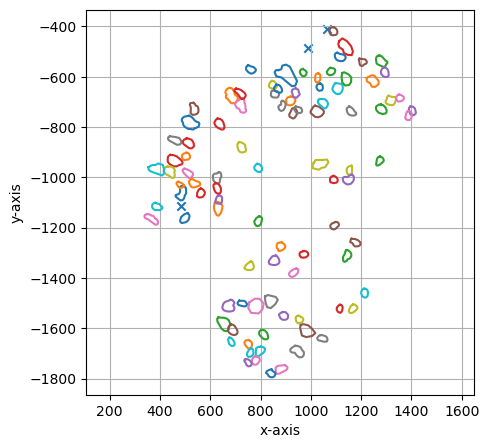

[106493. -41066.]
[  48530. -111332.]
[ 98833. -48752.]


In [99]:
QC_geojson_file(paths[1], calibration_points)
df, calib_np_array = load_geojson_file(paths[1], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)

### M1_Right_5exp11_Composite

12:53:13.73 | INFO | Geojson file loaded with shape (37, 5)
12:53:13.73 | INFO | Geometries in DataFrame: 25 Polygons, 9 LineStrings, 3 Points
12:53:13.74 | INFO |  17.65% of polygons are within calibration triangle
12:53:13.74 | WARNING | Less than 25% of the objects intersect with the calibration triangle
12:53:13.74 | WARNING | Polygons will most likely be warped, consider changing calib points
12:53:13.74 | DEBUG | Point geometries have been removed
12:53:13.74 | DEBUG | Checking for MultiPolygon objects
12:53:13.74 | DEBUG | Extracting coordinates from geometries
12:53:13.74 | SUCCESS | QC of geojson file complete


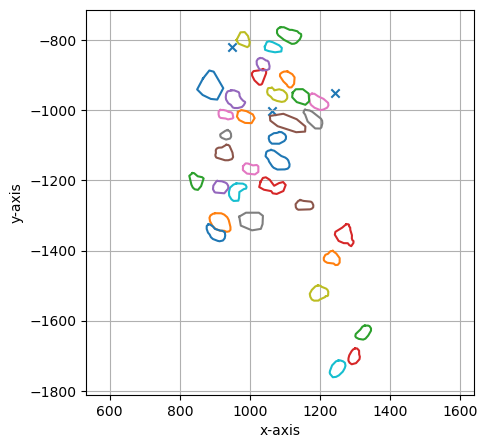

[124203. -94969.]
[ 94975. -81806.]
[ 106360. -100305.]


In [97]:
QC_geojson_file(paths[2], calibration_points)
df, calib_np_array = load_geojson_file(paths[2], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)

### M1_Right_2exp5_Composite

12:53:16.02 | INFO | Geojson file loaded with shape (56, 5)
12:53:16.02 | INFO | Geometries in DataFrame: 42 Polygons, 11 LineStrings, 3 Points


12:53:16.02 | INFO |  7.55% of polygons are within calibration triangle
12:53:16.02 | WARNING | Less than 25% of the objects intersect with the calibration triangle
12:53:16.02 | WARNING | Polygons will most likely be warped, consider changing calib points
12:53:16.03 | DEBUG | Point geometries have been removed
12:53:16.03 | DEBUG | Checking for MultiPolygon objects
12:53:16.03 | DEBUG | Extracting coordinates from geometries
12:53:16.03 | SUCCESS | QC of geojson file complete


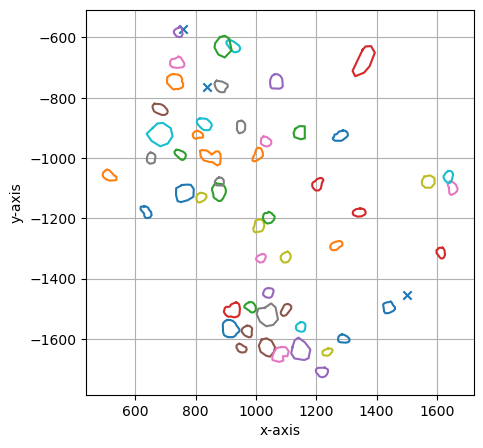

[ 83727. -76486.]
[ 75849. -57263.]
[ 150152. -145447.]


In [98]:
QC_geojson_file(paths[3], calibration_points)
df, calib_np_array = load_geojson_file(paths[3], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)